In [1]:
import json
import pandas as pd
import numpy as np

# Gemma output accuracy


In [3]:

with open("./prediction model data/output_gemma_final.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,General Reasoning,Why Positive,Positive,Why Negative,Negative,Why Neutral,Neutral,Stocks Mentioned,id
0,The post is a simple question asking for recom...,No positive sentiment detected.,0,No negative sentiment detected.,0,The post is a straightforward question about b...,10,[GME],laa9d4
1,The post expresses strong support and anticipa...,The use of rocket emojis (🚀) and the '💎🤲' symb...,9,There is no negative sentiment expressed in th...,0,The post is not neutral; it expresses a clear ...,0,[GME],la6xmz
2,The post expresses overwhelming enthusiasm and...,The post uses highly enthusiastic language ('L...,10,There is no negative sentiment expressed towar...,0,The post is purely emotional and lacks any neu...,0,[GME],l6d8j6
3,The post explicitly advises buying GME and fra...,The post directly encourages buying GME and in...,8,There's no negative sentiment expressed toward...,0,The post is not neutral; it expresses a clear ...,0,[GME],l68ikp
4,The post expresses a defiant attitude towards ...,"The post advocates for action related to GME, ...",7,The post expresses some uncertainty ('Or oppor...,2,The post primarily focuses on GME and related ...,3,"[GME, BTC]",l83m9b


In [4]:
df = df[['id','Positive','Negative','Neutral', 'Stocks Mentioned']]

In [5]:
hum_ann = pd.read_excel("/Users/jasleenmadan/Documents/Workspace/Projects/Field_Project/Annotated data/Master_annotation.xlsx", sheet_name="Sheet3")

In [6]:
hum_ann.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       600 non-null    int64  
 1   ID               600 non-null    object 
 2   TEXT             600 non-null    object 
 3   Sentiment_label  578 non-null    object 
 4   Positive         600 non-null    float64
 5   Negative         600 non-null    float64
 6   Neutral          600 non-null    float64
 7   flag             600 non-null    int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 37.6+ KB


In [7]:
hum_ann = hum_ann.drop("Unnamed: 0", axis=1)
hum_ann[['Positive', 'Negative', 'Neutral']] = hum_ann[['Positive', 'Negative', 'Neutral']].round(decimals=0)
hum_ann.head()

,ID,TEXT,Sentiment_label,Positive,Negative,Neutral,flag
0,laa9d4,Best broker to buy GME stocks?,Neutral,3.0,0.0,8.0,0
1,la6xmz,"$400 GME Holders, we come back for you🚀💎🤲",Positive,9.0,0.0,0.0,0
2,l6d8j6,Let’s fucking goooooo thanks mates GME 🦄🦄🦄🦄🦄🦄🦄...,Positive,10.0,0.0,0.0,0
3,l68ikp,PSA: The shitload of bots shilling against GME...,Positive,8.0,1.0,2.0,0
4,l83m9b,"If they block your GME , block the chain. Snag...",Neutral,5.0,1.0,6.0,0


In [8]:
df1 = df.rename(columns={'Positive': 'Positive_Gemma', 'Neutral': 'Neutral_Gemma', 'Negative': 'Negative_Gemma'})

In [9]:
merge_df = pd.concat([hum_ann, df1], axis=1)
merge_df = merge_df.round()

In [10]:
def assign_label(row):
    vals = row[['Positive_Gemma','Negative_Gemma','Neutral_Gemma']]
    if vals.isna().all():
        return np.nan
    max_val = vals.max()
    
    # go in priority order and return the first that matches
    for col, label in [
        ('Positive_Gemma', 'Positive'),
        ('Negative_Gemma', 'Negative'),
        ('Neutral_Gemma',  'Neutral')
    ]:
        if vals[col] == max_val:
            return label
# Apply to DataFrame
merge_df['Sentiment_Gemma'] = merge_df.apply(assign_label, axis=1)

In [11]:
merge_df = merge_df[merge_df['flag'] != 1]
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541 entries, 0 to 599
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                541 non-null    object 
 1   TEXT              541 non-null    object 
 2   Sentiment_label   541 non-null    object 
 3   Positive          541 non-null    float64
 4   Negative          541 non-null    float64
 5   Neutral           541 non-null    float64
 6   flag              541 non-null    int64  
 7   id                541 non-null    object 
 8   Positive_Gemma    541 non-null    int64  
 9   Negative_Gemma    541 non-null    int64  
 10  Neutral_Gemma     541 non-null    int64  
 11  Stocks Mentioned  541 non-null    object 
 12  Sentiment_Gemma   541 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 59.2+ KB


In [12]:
merge_df['Sentiment_label'].value_counts()

Sentiment_label
Positive    356
Neutral     140
Negative     45
Name: count, dtype: int64

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

total_rows = len(merge_df)

clean = merge_df.dropna(subset=['Sentiment_label', 'Sentiment_Gemma'])

processed_rows = len(clean)
dropped_rows   = total_rows - processed_rows

print(f"Total rows:     {total_rows}")
print(f"Rows processed: {processed_rows}")
print(f"Rows dropped:   {dropped_rows}\n")

clean['Sentiment_label'] = clean['Sentiment_label'].astype(str)
clean['Sentiment_Gemma'] = clean['Sentiment_Gemma'].astype(str)

# Compute metrics
labels = ['Positive', 'Negative', 'Neutral']
y_true = clean['Sentiment_label']
y_pred = clean['Sentiment_Gemma']

print("Accuracy:", accuracy_score(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred, labels=labels))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    digits=2,
    zero_division=0 
))


Total rows:     541
Rows processed: 541
Rows dropped:   0

Accuracy: 0.8040665434380776

Confusion Matrix:
[[351   2   3]
 [ 18  19   8]
 [ 72   3  65]]

Classification Report:
              precision    recall  f1-score   support

    Positive       0.80      0.99      0.88       356
    Negative       0.79      0.42      0.55        45
     Neutral       0.86      0.46      0.60       140

    accuracy                           0.80       541
   macro avg       0.81      0.62      0.68       541
weighted avg       0.81      0.80      0.78       541



In [14]:
#comparing continuous scores
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Drop rows with NaNs 
df_scores = merge_df.dropna(subset=['Sentiment_label','Positive', 'Positive_Gemma'])

y_true = df_scores['Positive'].values
y_pred = df_scores['Positive_Gemma'].values

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r    = np.corrcoef(y_true, y_pred)[0,1]
r2   = r2_score(y_true, y_pred)

print(f"Samples evaluated: {len(y_true)}")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"r:    {r:.3f}")
print(f"R²:   {r2:.3f}")

Samples evaluated: 541
MAE:  1.569
RMSE: 2.320
r:    0.790
R²:   0.566


In [15]:
df_scores = merge_df.dropna(subset=['Sentiment_label','Neutral', 'Neutral_Gemma'])
y_true = df_scores['Neutral'].values
y_pred = df_scores['Neutral_Gemma'].values

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r    = np.corrcoef(y_true, y_pred)[0,1]
r2   = r2_score(y_true, y_pred)

print(f"Samples evaluated: {len(y_true)}")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"r:    {r:.3f}")
print(f"R²:   {r2:.3f}")

Samples evaluated: 541
MAE:  1.699
RMSE: 2.476
r:    0.704
R²:   0.356


In [16]:
df_scores = merge_df.dropna(subset=['Sentiment_label','Negative', 'Negative_Gemma'])
y_true = df_scores['Negative'].values
y_pred = df_scores['Negative_Gemma'].values

# Compute metrics
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r    = np.corrcoef(y_true, y_pred)[0,1]
r2   = r2_score(y_true, y_pred)

print(f"Samples evaluated: {len(y_true)}")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"r:    {r:.3f}")
print(f"R²:   {r2:.3f}")

Samples evaluated: 541
MAE:  0.765
RMSE: 1.538
r:    0.669
R²:   0.421


In [17]:
#evaluating fingpt classification 
with open("./prediction model data/output_finGPT.json", "r") as f:
    data = json.load(f)

df_fin = pd.DataFrame(data)

df_fin.head()

,id,sentence,sentiment
0,0,Best broker to buy GME stocks?,neutral
1,1,"$400 GME Holders, we come back for you🚀💎🤲",positive
2,2,Let’s fucking goooooo thanks mates GME 🦄🦄🦄🦄🦄🦄🦄...,positive
3,3,PSA: The shitload of bots shilling against GME...,neutral
4,4,"If they block your GME , block the chain. Snag...",neutral


In [18]:
merge_df = pd.concat([hum_ann, df_fin], axis=1)
merge_df['Sentiment_label'] = merge_df['Sentiment_label'].str.lower()

In [19]:
merge_df['sentiment'] = merge_df['sentiment'].astype(str).str.strip()
valid_labels = ['positive', 'neutral', 'negative']
merge_df['sentiment'] = merge_df['sentiment'].str.extract(r'\b(' + '|'.join(valid_labels) + r')\b', expand=False)
merge_df['sentiment'] = merge_df['sentiment'].str.lower()


In [20]:
merge_df = merge_df[merge_df['flag'] != 1]
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541 entries, 0 to 599
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               541 non-null    object 
 1   TEXT             541 non-null    object 
 2   Sentiment_label  541 non-null    object 
 3   Positive         541 non-null    float64
 4   Negative         541 non-null    float64
 5   Neutral          541 non-null    float64
 6   flag             541 non-null    int64  
 7   id               541 non-null    int64  
 8   sentence         541 non-null    object 
 9   sentiment        527 non-null    object 
dtypes: float64(3), int64(2), object(5)
memory usage: 46.5+ KB


In [21]:
total_rows = len(merge_df)

clean = merge_df.dropna(subset=['Sentiment_label', 'sentiment'])


processed_rows = len(clean)
dropped_rows   = total_rows - processed_rows

print(f"Total rows:     {total_rows}")
print(f"Rows processed: {processed_rows}")
print(f"Rows dropped:   {dropped_rows}\n")

clean['Sentiment_label'] = clean['Sentiment_label'].astype(str)
clean['sentiment'] = clean['sentiment'].astype(str)

# Compute metrics
labels = ['positive', 'negative', 'neutral']
y_true = clean['Sentiment_label']
y_pred = clean['sentiment']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred, labels=labels))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    digits=2,
    zero_division=0 
))


Total rows:     541
Rows processed: 527
Rows dropped:   14

Accuracy: 0.45351043643263755

Confusion Matrix:
[[116   6 228]
 [  4  10  31]
 [ 10   9 113]]

Classification Report:
              precision    recall  f1-score   support

    positive       0.89      0.33      0.48       350
    negative       0.40      0.22      0.29        45
     neutral       0.30      0.86      0.45       132

    accuracy                           0.45       527
   macro avg       0.53      0.47      0.41       527
weighted avg       0.70      0.45      0.46       527



/var/folders/8r/lp807dgx5l1g14nqdf2kk0_m0000gn/T/ipykernel_69124/1481710697.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['Sentiment_label'] = clean['Sentiment_label'].astype(str)
/var/folders/8r/lp807dgx5l1g14nqdf2kk0_m0000gn/T/ipykernel_69124/1481710697.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['sentiment'] = clean['sentiment'].astype(str)


# Evaluating Finbert Classification

In [23]:
 
df_bert = pd.read_csv('./prediction model data/output_finbert.csv')
df_bert.head()

,label,score
0,Positive,0.999954
1,Neutral,0.999990
2,Neutral,0.999997
3,Positive,0.999982
4,Negative,0.997200


In [24]:
merge_df1 = pd.concat([hum_ann, df_bert], axis=1)
merge_df1.head()

,ID,TEXT,Sentiment_label,Positive,Negative,Neutral,flag,label,score
0,laa9d4,Best broker to buy GME stocks?,Neutral,3.0,0.0,8.0,0,Positive,0.999954
1,la6xmz,"$400 GME Holders, we come back for you🚀💎🤲",Positive,9.0,0.0,0.0,0,Neutral,0.999990
2,l6d8j6,Let’s fucking goooooo thanks mates GME 🦄🦄🦄🦄🦄🦄🦄...,Positive,10.0,0.0,0.0,0,Neutral,0.999997
3,l68ikp,PSA: The shitload of bots shilling against GME...,Positive,8.0,1.0,2.0,0,Positive,0.999982
4,l83m9b,"If they block your GME , block the chain. Snag...",Neutral,5.0,1.0,6.0,0,Negative,0.997200


In [25]:
merge_df1 = merge_df1.rename(columns={'label': 'sentiment_finbert'})
merge_df1 = merge_df1[merge_df1['flag'] != 1]

In [26]:
total_rows = len(merge_df1)

clean = merge_df1.dropna(subset=['Sentiment_label', 'sentiment_finbert'])


processed_rows = len(clean)
dropped_rows   = total_rows - processed_rows

print(f"Total rows:     {total_rows}")
print(f"Rows processed: {processed_rows}")
print(f"Rows dropped:   {dropped_rows}\n")

clean['Sentiment_label'] = clean['Sentiment_label'].astype(str)
clean['sentiment_finbert'] = clean['sentiment_finbert'].astype(str)

# Compute metrics
labels = ['Positive', 'Negative', 'Neutral']
y_true = clean['Sentiment_label']
y_pred = clean['sentiment_finbert']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred, labels=labels))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    digits=2,
    zero_division=0 
))


Total rows:     541
Rows processed: 541
Rows dropped:   0

Accuracy: 0.4787430683918669

Confusion Matrix:
[[136  18 202]
 [  6   9  30]
 [  8  18 114]]

Classification Report:
              precision    recall  f1-score   support

    Positive       0.91      0.38      0.54       356
    Negative       0.20      0.20      0.20        45
     Neutral       0.33      0.81      0.47       140

    accuracy                           0.48       541
   macro avg       0.48      0.47      0.40       541
weighted avg       0.70      0.48      0.49       541



In [27]:
#evaluating vader classification 
df_vader = pd.read_csv('./prediction model data/output_vader.csv')


In [28]:
merge_df1 = pd.concat([hum_ann, df_vader], axis=1)
merge_df1 = merge_df1.drop(['original_text', 'cleaned_text'], axis=1)
merge_df1.head()

,ID,TEXT,Sentiment_label,Positive,Negative,Neutral,flag,compound_score,positive_score,neutral_score,negative_score,sentiment
0,laa9d4,Best broker to buy GME stocks?,Neutral,3.0,0.0,8.0,0,0.6369,0.457,0.543,0.000,positive
1,la6xmz,"$400 GME Holders, we come back for you🚀💎🤲",Positive,9.0,0.0,0.0,0,0.8310,0.464,0.536,0.000,positive
2,l6d8j6,Let’s fucking goooooo thanks mates GME 🦄🦄🦄🦄🦄🦄🦄...,Positive,10.0,0.0,0.0,0,0.4902,0.185,0.815,0.000,positive
3,l68ikp,PSA: The shitload of bots shilling against GME...,Positive,8.0,1.0,2.0,0,0.5106,0.136,0.864,0.000,positive
4,l83m9b,"If they block your GME , block the chain. Snag...",Neutral,5.0,1.0,6.0,0,-0.6249,0.125,0.576,0.298,negative


In [29]:
merge_df1['sentiment'] = merge_df1['sentiment'].str.capitalize()
merge_df1 = merge_df1[merge_df1['flag'] != 1]
merge_df1['sentiment'].value_counts()

sentiment
Positive    317
Negative    114
Neutral     110
Name: count, dtype: int64

In [30]:
total_rows = len(merge_df1)

clean = merge_df1.dropna(subset=['Sentiment_label', 'sentiment'])


processed_rows = len(clean)
dropped_rows   = total_rows - processed_rows

print(f"Total rows:     {total_rows}")
print(f"Rows processed: {processed_rows}")
print(f"Rows dropped:   {dropped_rows}\n")

clean['Sentiment_label'] = clean['Sentiment_label'].astype(str)
clean['sentiment'] = clean['sentiment'].astype(str)

# Compute metrics
labels = ['Positive', 'Negative', 'Neutral']
y_true = clean['Sentiment_label']
y_pred = clean['sentiment']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred, labels=labels))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    digits=2,
    zero_division=0 
))


Total rows:     541
Rows processed: 541
Rows dropped:   0

Accuracy: 0.600739371534196

Confusion Matrix:
[[254  60  42]
 [ 20  14  11]
 [ 43  40  57]]

Classification Report:
              precision    recall  f1-score   support

    Positive       0.80      0.71      0.75       356
    Negative       0.12      0.31      0.18        45
     Neutral       0.52      0.41      0.46       140

    accuracy                           0.60       541
   macro avg       0.48      0.48      0.46       541
weighted avg       0.67      0.60      0.63       541



In [31]:
#calculating ICC for human annotators and Fleiss's Kappa
hum_ann1 = pd.read_excel("/Users/jasleenmadan/Documents/Workspace/Projects/Field_Project/Annotated data/Master_annotation.xlsx", sheet_name="recalibrated values")

In [32]:

hum_ann_filtered = hum_ann_filtered[
    ~(
        (hum_ann_filtered['FLAG_01'] == 1) |
        (hum_ann_filtered['FLAG_02'] == 1) |
        (hum_ann_filtered['FLAG_03'] == 1) |
        (hum_ann_filtered['FLAG_04'] == 1) |
        (hum_ann_filtered['FLAG_05'] == 1)
    )
]


NameError: name 'hum_ann_filtered' is not defined

In [ ]:
hum_ann_filtered.info()

In [ ]:
wide = hum_ann_filtered[['Unnamed: 0','POSTIVE_01','POSTIVE_02', 'POSTIVE_03', 'POSTIVE _04', 'POSTIVE _05']]
long = pd.melt(
    wide,
    id_vars=['Unnamed: 0'],
    value_vars=['POSTIVE_01','POSTIVE_02','POSTIVE_03', 'POSTIVE _04', 'POSTIVE _05'],
    var_name='rater',
    value_name='pos_score'
)

icc_pos_results = pg.intraclass_corr(
    data=long,
    targets='Unnamed: 0',
    raters='rater',
    ratings='pos_score'
)

#Extract
icc2  = icc_pos_results.loc[icc_pos_results['Type'] == 'ICC2', 'ICC'].values[0]
icc2k = icc_pos_results.loc[icc_pos_results['Type'] == 'ICC2k', 'ICC'].values[0]

print(f"ICC(2,1) = {icc2:.3f}     (single rater)")
print(f"ICC(2,3) = {icc2k:.3f}     (average of 5 raters)")

In [ ]:
wide = hum_ann_filtered[['Unnamed: 0', 'NEGATIVE_01', 'NEGATIVE_02','NEGATIVE_03', 'NEGATIVE_04', 'NEGATIVE_05']]
long = pd.melt(
    wide,
    id_vars=['Unnamed: 0'],
    value_vars=['NEGATIVE_01', 'NEGATIVE_02','NEGATIVE_03', 'NEGATIVE_04', 'NEGATIVE_05'],
    var_name='rater',
    value_name='neg_score'
)

icc_neg_results = pg.intraclass_corr(
    data=long,
    targets='Unnamed: 0',
    raters='rater',
    ratings='neg_score'
)

#Extract
icc2  = icc_neg_results.loc[icc_neg_results['Type'] == 'ICC2', 'ICC'].values[0]
icc2k = icc_neg_results.loc[icc_neg_results['Type'] == 'ICC2k', 'ICC'].values[0]

print(f"ICC(2,1) = {icc2:.3f}     (single rater)")
print(f"ICC(2,3) = {icc2k:.3f}     (average of 5 raters)")

In [ ]:
wide = hum_ann_filtered[['Unnamed: 0','NEUTRAL_01', 'NEUTRAL_02', 'NEUTRAL_03', 'NEUTRAL_04', 'NEUTRAL_05']]
long = pd.melt(
    wide,
    id_vars=['Unnamed: 0'],
    value_vars=['NEUTRAL_01', 'NEUTRAL_02','NEUTRAL_03', 'NEUTRAL_04', 'NEUTRAL_05'],
    var_name='rater',
    value_name='neu_score'
)

icc_neu_results = pg.intraclass_corr(
    data=long,
    targets='Unnamed: 0',
    raters='rater',
    ratings='neu_score'
)

#Extract
icc2  = icc_neu_results.loc[icc_neu_results['Type'] == 'ICC2', 'ICC'].values[0]
icc2k = icc_neu_results.loc[icc_neu_results['Type'] == 'ICC2k', 'ICC'].values[0]

print(f"ICC(2,1) = {icc2:.3f}     (single rater)")
print(f"ICC(2,3) = {icc2k:.3f}     (average of 5 raters)")

In [ ]:
#using Fleiss's Kappa for categorical label sentiments
from statsmodels.stats.inter_rater import fleiss_kappa
df_cat = hum_ann_filtered[['Sentiment_01','Sentiment_02','Sentiment_03', 'Sentiment_04', 'Sentiment_05']]
df_cat = df_cat.reset_index(drop=True)
categories = ['Positive', 'Negative', 'Neutral']
count_matrix = np.zeros((len(df_cat), 3), dtype=int)

for i, row in df_cat.iterrows():
    for j, cat in enumerate(categories):
        count_matrix[i, j] = (row.values == cat).sum()
kappa = fleiss_kappa(count_matrix)
print(f"Fleiss’ κ = {kappa:.4f}")

# Checking human annotator performance against ground truth 

In [33]:
hum_ann2 = hum_ann1[['Sentiment_01.1','Sentiment_02.1','Sentiment_03.1', 'Sentiment_04.1', 'Sentiment_05.1', 'Sentiment_label']]
hum_ann2 = hum_ann2.fillna('None').astype(str)
def evaluate_annotator(pred_col_name):
    y_true = hum_ann2['Sentiment_label']
    y_pred = hum_ann2[pred_col_name]
    
    print(f"Evaluation for {pred_col_name}:")
    print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}\n")
    
    labels = ['Positive', 'Negative', 'Neutral']
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred, labels=labels))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=labels))
    print("-" * 60)

# Evaluate each annotator
evaluate_annotator('Sentiment_01.1')
evaluate_annotator('Sentiment_02.1')
evaluate_annotator('Sentiment_03.1')
evaluate_annotator('Sentiment_04.1')
evaluate_annotator('Sentiment_05.1')
##average accuracy is 0. 87


Evaluation for Sentiment_01.1:

Accuracy: 0.8416666666666667

Confusion Matrix:
[[336   3  27]
 [  4  39   8]
 [ 24   8 114]]

Classification Report:
              precision    recall  f1-score   support

    Positive       0.92      0.91      0.91       371
    Negative       0.76      0.75      0.76        52
     Neutral       0.74      0.74      0.74       155

   micro avg       0.86      0.85      0.85       578
   macro avg       0.81      0.80      0.80       578
weighted avg       0.86      0.85      0.85       578

------------------------------------------------------------
Evaluation for Sentiment_02.1:

Accuracy: 0.8566666666666667

Confusion Matrix:
[[330   6  31]
 [  0  44   5]
 [ 12  13 127]]

Classification Report:
              precision    recall  f1-score   support

    Positive       0.95      0.89      0.92       371
    Negative       0.68      0.85      0.75        52
     Neutral       0.77      0.82      0.79       155

   micro avg       0.87      0.87      0

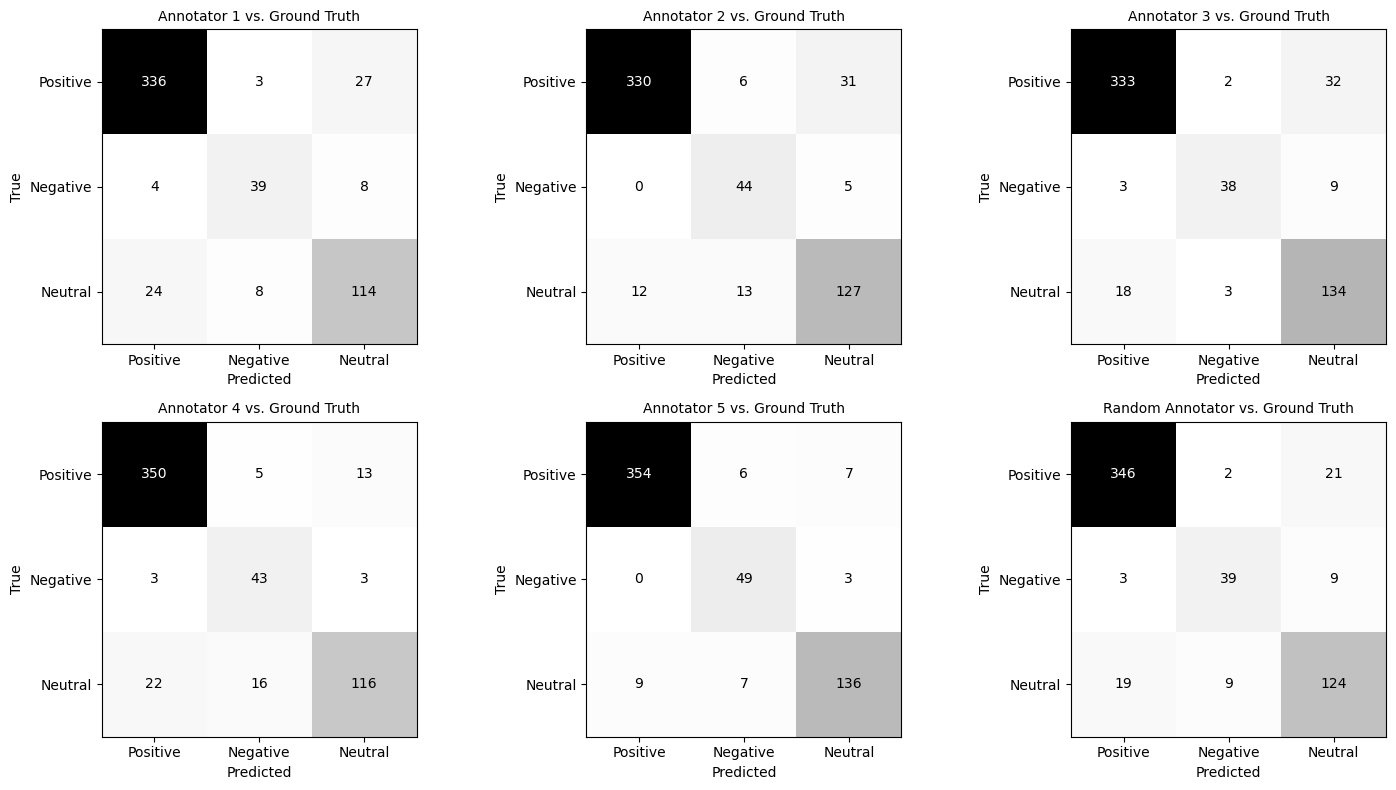

In [49]:

import matplotlib.pyplot as plt

labels = ['Positive', 'Negative', 'Neutral']

def plot_confusion_heatmap(ax, y_true, y_pred, labels, title, cmap='Greys'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # Set axis labels and title
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title, fontsize=10)

    # Normalize for deciding text color
    vmax = cm.max()
    for i in range(len(labels)):
        for j in range(len(labels)):
            value = cm[i, j]
            text_color = 'white' if value > vmax * 0.5 else 'black'
            ax.text(j, i, value, ha='center', va='center', color=text_color)

# Example for plotting all annotators and a random one in a grid
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Ground truth
y_true = hum_ann2['Sentiment_label'].values

# Annotator predictions
for i in range(5):
    y_pred = hum_ann2[f'Sentiment_0{i+1}.1']
    plot_confusion_heatmap(
        axes[i],
        y_true,
        y_pred,
        labels,
        f'Annotator {i+1} vs. Ground Truth'
    )

# Random annotator
np.random.seed(42)
pred_matrix = hum_ann2[[f'Sentiment_0{i+1}.1' for i in range(5)]].values
random_preds = [np.random.choice(row) for row in pred_matrix]

plot_confusion_heatmap(
    axes[5],
    y_true,
    random_preds,
    labels,
    'Random Annotator vs. Ground Truth'
)

plt.tight_layout()
plt.savefig('Heatmap annotators.png')
plt.show()
